# London Food Hygeine Rating Study

In [1]:
import requests
import json
import geopandas as gpd
import pandas as pd
from collections import Counter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from scipy import stats

API from UK Government:

In [2]:
url = "http://api.ratings.food.gov.uk/"

headers = {"x-api-version": "2",
            "accept": "application/json",
            "content-type": "application/json"
            }

Getting all London Authorities and their IDs:

In [4]:
response = requests.get(url + "Authorities", headers = headers)

data = response.json()
authorities = data["authorities"]
df = pd.DataFrame.from_dict(authorities)
London_Authorities = df[df['RegionName']=='London']

London_Authorities_keydata = London_Authorities[["LocalAuthorityId","Name"]]

print(London_Authorities_keydata)


     LocalAuthorityId                        Name
15                 88        Barking and Dagenham
16                 89                      Barnet
25                 90                      Bexley
39                 91                       Brent
45                 92                     Bromley
55                 93                      Camden
74                 95  City of London Corporation
85                 94                     Croydon
100                96                      Ealing
118                97                     Enfield
139                98                   Greenwich
142                99                     Hackney
145               100      Hammersmith and Fulham
147               101                    Haringey
150               102                      Harrow
155               103                    Havering
160               104                  Hillingdon
163               105                    Hounslow
172               106                   Islington


Each food business is categorised by its business type. This  study focuses on takeaways only, though it could be expanded to other establishments.

In [386]:
response = requests.get(url + "BusinessTypes/basic", headers = headers)
data = response.json()
print(data)

{'businessTypes': [{'BusinessTypeId': -1, 'BusinessTypeName': 'All', 'links': [{'rel': 'self', 'href': 'http://api.ratings.food.gov.uk/businesstypes/-1'}]}, {'BusinessTypeId': 7, 'BusinessTypeName': 'Distributors/Transporters', 'links': [{'rel': 'self', 'href': 'http://api.ratings.food.gov.uk/businesstypes/7'}]}, {'BusinessTypeId': 7838, 'BusinessTypeName': 'Farmers/growers', 'links': [{'rel': 'self', 'href': 'http://api.ratings.food.gov.uk/businesstypes/7838'}]}, {'BusinessTypeId': 5, 'BusinessTypeName': 'Hospitals/Childcare/Caring Premises', 'links': [{'rel': 'self', 'href': 'http://api.ratings.food.gov.uk/businesstypes/5'}]}, {'BusinessTypeId': 7842, 'BusinessTypeName': 'Hotel/bed & breakfast/guest house', 'links': [{'rel': 'self', 'href': 'http://api.ratings.food.gov.uk/businesstypes/7842'}]}, {'BusinessTypeId': 14, 'BusinessTypeName': 'Importers/Exporters', 'links': [{'rel': 'self', 'href': 'http://api.ratings.food.gov.uk/businesstypes/14'}]}, {'BusinessTypeId': 7839, 'BusinessTyp

This function calculates the overall hygeine rating of a business based on its three individual ratings ('how hygienically the food is handled', 'the physical condition of the business', 'how the business manages ways of keeping food safe'.) More information about the Food Hygeine Rating Scheme is available at https://www.food.gov.uk/safety-hygiene/food-hygiene-rating-scheme#understanding-ratings.  

In [7]:
def hygeine_rating(dict):
    if len(dict)!=3:
        return("error")
    try: 
        limits = [5,10,10,15,20,25]
        highest = max(dict.values())
        score = sum(dict.values())

        if score > 50 or highest > 20: 
            return 0
        elif score <= 15:
            return(5 - limits.index(highest))
        elif score == 20:
            return(4 - limits[1:].index(highest))
        elif score <= 30:
            return(3 - limits[2:].index(highest))
        elif score <= 40:
            return(2 - limits[3:].index(highest))
        elif score <= 50:
            return(1 - limits[4:].index(highest))
    except:
        return("NaN")

Test just for Harrow

In [17]:
response = requests.get(url + "Establishments?localAuthorityId= 102&businessTypeId=7844  ", headers = headers)
data = response.json()
establishments = data["establishments"]
df = pd.DataFrame.from_dict(establishments)

df_keydata = df[["FHRSID","BusinessName","scores","geocode"]]
df_keydata["rating"] = df["scores"].apply(hygeine_rating)

ratings_frequencies = Counter(df_keydata["rating"])
print(ratings_frequencies)

Counter({5: 79, 4: 58, 3: 31, 'NaN': 26, 2: 6, 1: 3})


C:\Users\anujb\AppData\Local\Temp/ipykernel_28436/3887899892.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_keydata["rating"] = df["scores"].apply(hygeine_rating)


Function to get the frequencies of ratings across all takeaways for a given London Borough. Then a weighted average is used to obtain an overall score for a Borough.

In [18]:
 def authority_ratings_frequencies(LocalAuthorityId): #gets all ratings for an authority in a dictionary
    response = requests.get(url + f"Establishments?localAuthorityId={LocalAuthorityId}&businessTypeId=7844  ", headers = headers)
    data = response.json()
    df = pd.DataFrame.from_dict(data["establishments"]) #dataframe with establishments for authority
    df_keydata = df[["FHRSID","BusinessName","scores","geocode"]]
    df_keydata["rating"] = df["scores"].apply(hygeine_rating)
    ratings_frequencies = Counter(df_keydata["rating"])
    return(ratings_frequencies)

In [19]:
def weighted_avg(dict): #calculate weighted average for all ratings excluding NaNs
    w_sum = sum(item[0]*item[1] for item in dict.items() if item[0] != "NaN")
    w_avg = w_sum / (sum(dict.values()) - dict['NaN'])
    return(w_avg)

In [26]:
London_Authorities_keydata["rating summary"] = London_Authorities_keydata["LocalAuthorityId"].apply(authority_ratings_frequencies)
London_Authorities_keydata["Number of takeaways with valid rating"] = London_Authorities_keydata["rating summary"].apply(lambda x: sum(x.values()) - x['NaN'] )

C:\Users\anujb\AppData\Local\Temp/ipykernel_28436/3331614313.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_keydata["rating"] = df["scores"].apply(hygeine_rating)
C:\Users\anujb\AppData\Local\Temp/ipykernel_28436/1040802720.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  London_Authorities_keydata["rating summary"] = London_Authorities_keydata["LocalAuthorityId"].apply(authority_ratings_frequencies)
C:\Users\anujb\AppData\Local\Temp/ipykernel_28436/1040802720.py:2: SettingWithCopyWarning: 
A val

In [33]:
London_Authorities_keydata.sort_values("Name")
London_Authorities_keydata["GSS_CODE"] = London_map["GSS_CODE"].values
London_Authorities_keydata["Average hygeine rating"] =London_Authorities_keydata["rating summary"].apply(weighted_avg)
London_Authorities_keydata.head()


C:\Users\anujb\AppData\Local\Temp/ipykernel_28436/3487156161.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  London_Authorities_keydata["GSS_CODE"] = London_map["GSS_CODE"].values
C:\Users\anujb\AppData\Local\Temp/ipykernel_28436/3487156161.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  London_Authorities_keydata["Average hygeine rating"] =London_Authorities_keydata["rating summary"].apply(weighted_avg)


,LocalAuthorityId,Name,rating summary,Number of takeaways with valid rating,GSS_CODE,Average hygeine rating
15,88,Barking and Dagenham,"{5: 69, 'NaN': 44, 4: 57, 3: 56, 2: 7, 1: 5, 0...",195,E09000002,3.897436
16,89,Barnet,"{'NaN': 37, 5: 75, 4: 57, 3: 41, 2: 17, 1: 12}",202,E09000003,3.821782
25,90,Bexley,"{5: 68, 'NaN': 35, 4: 58, 3: 55, 2: 6, 0: 1}",188,E09000004,3.984043
39,91,Brent,"{5: 205, 'NaN': 102, 4: 83, 3: 38, 2: 12, 1: 2...",342,E09000005,4.377193
45,92,Bromley,"{5: 81, 'NaN': 28, 4: 48, 3: 48, 2: 8, 1: 7}",192,E09000006,3.979167


Map data containing boundaries of all London Authorities

In [34]:
London_map = gpd.read_file(r"../London Borough maps\London_Borough_Excluding_MHW.shp")
London_map = London_map.sort_values("NAME")

<AxesSubplot:>

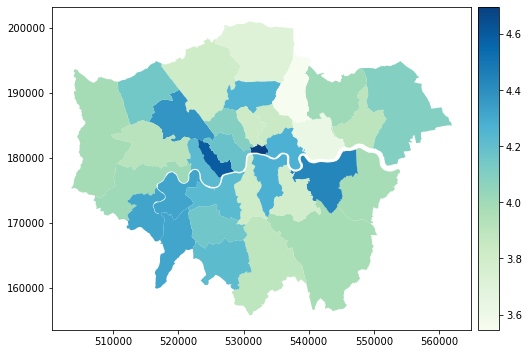

In [45]:
#Hygeine ratings across Boroughs 

London_map_and_ratings = London_map.merge(London_Authorities_keydata, on = "GSS_CODE")
fig, ax = plt.subplots(1, figsize = (8,8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad = 0.1)

London_map_and_ratings.plot(column="Average hygeine rating", cmap="GnBu", ax = ax,  legend = True, cax = cax)



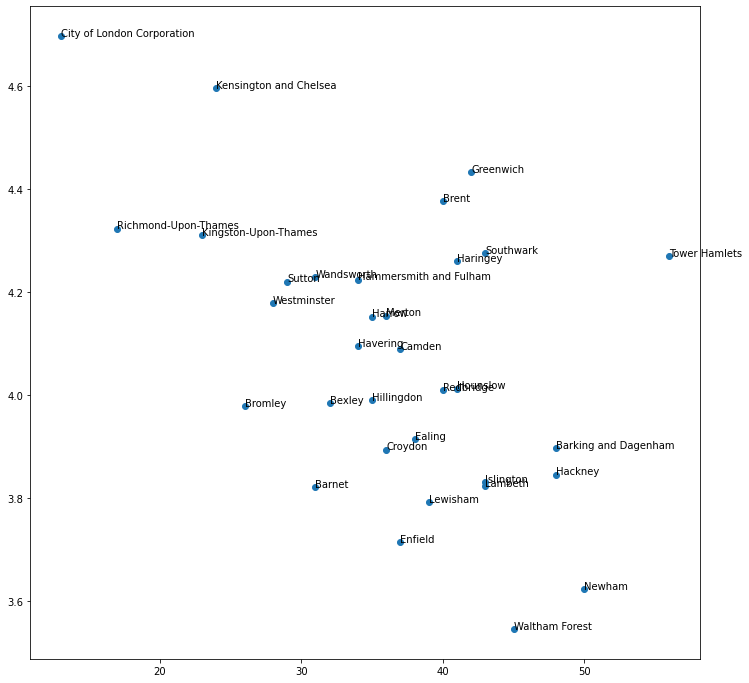

In [46]:
#Scatter plot of hygeine rating and Borough Child Poverty Rate 

London_KPIs = pd.read_csv("Borough ratings across key indicators (2021).csv")
London_KPIs.sort_values("Area")
plt.figure(figsize=(12,12))
x = London_KPIs["Child poverty rate"]
y = London_Authorities_keydata["Average hygeine rating"].tolist()
plt.scatter(x,y)



for num, auth in enumerate(London_Authorities_keydata["Name"]):
    plt.annotate(auth, (x[num], y[num]))



correlation between hygeine rating and Borough Child Poverty Rate 

In [44]:
slope, intercept, r, p , std_err = stats.linregress(x,y)
print(r)

-0.5177812087071393
